In [3]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


import xgboost as xgb


In [4]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()
    

In [18]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train = average_speakers(train)
    
    british_df = pd.read_csv('british_mfcc.csv')
    feature_cols = [x for x in british_df.columns if 'feature' in x]
    
    return train, test, british_df[feature_cols]
    


train, test, british_df = load_data()

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


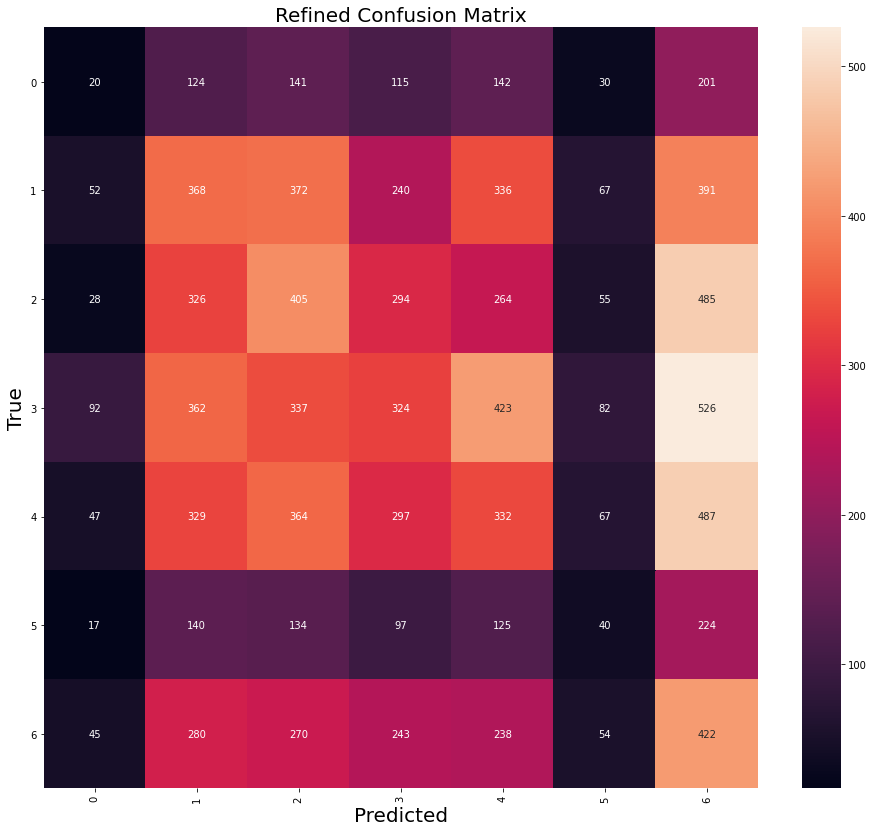

XGBoost accuracy: 0.17606412382531786
XGBoost number of mislabeled points out of a total 10854 points : 8943
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.066445     0.190772     0.200198     0.201242     0.178495   
recall       0.025873     0.201533     0.218094     0.150979     0.172647   
f1-score     0.037244     0.196005     0.208763     0.172524     0.175522   
support    773.000000  1826.000000  1857.000000  2146.000000  1923.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.101266     0.154240  0.176064      0.156094      0.171794  
recall       0.051480     0.271907  0.176064      0.156073      0.176064  
f1-score     0.068259     0.196828  0.176064      0.150735      0.169583  
support    777.000000  1552.000000  0.176064  10854.000000  10854.000000  


In [19]:
def xgb_me(train, test, display_conf=True, word = None, accents=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
        
    x_boost = xgb.XGBClassifier()
    
    x_boost.fit(X_train, y_train)
    
    y_pred = x_boost.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"XGBoost accuracy: {acc}")
        print(f"XGBoost number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return x_boost, y_pred, conf_df, classification_report(y_test, y_pred), acc


x_boost_whole, x_boost_pred_whole, x_boost_conf_whole, x_boost_mat_whole, acc = xgb_me(train, test)

In [35]:
british_pred = x_boost_whole.predict(british_df)

whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])
whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR7    398
DR2     96
DR3     88
DR4     67
DR5     57
DR6     21
DR1      5
Name: pred_accent, dtype: int64


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,pred_tally,pred_percent
pred_accent,,
DR1,5,0.683060
DR2,96,13.114754
DR3,88,12.021858
DR4,67,9.153005
DR5,57,7.786885
DR6,21,2.868852
DR7,398,54.371585


In [21]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test



In [22]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_train.head()

,speaker,word,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,accent,region
0,FAEM0,a,-353.348083,134.518519,-9.184594,-18.755492,-21.228213,-6.953157,-22.371318,-27.997338,-5.364247,4.490220,-6.668658,0.257785,North,North
1,FAEM0,after,-347.818909,106.672279,-45.025673,18.032808,-14.631424,-27.376530,-19.641098,-15.697500,1.943836,-9.809213,4.143702,-5.511507,North,North
2,FAEM0,all,-360.966278,126.600243,-24.294479,-38.255478,-69.742477,-17.396694,20.758194,-35.852512,-4.462066,-16.974424,-4.133724,-1.038600,North,North
3,FAEM0,always,-317.568298,108.726196,-11.648054,-37.803394,-61.665752,-5.345030,0.926592,-29.949045,-6.787814,-16.826244,4.379314,-9.666162,North,North
4,FAEM0,an,-392.887268,107.063339,-18.115166,39.589870,-27.925322,-45.015396,-20.218822,-21.476480,0.229233,-33.994270,3.304021,-11.966344,North,North


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


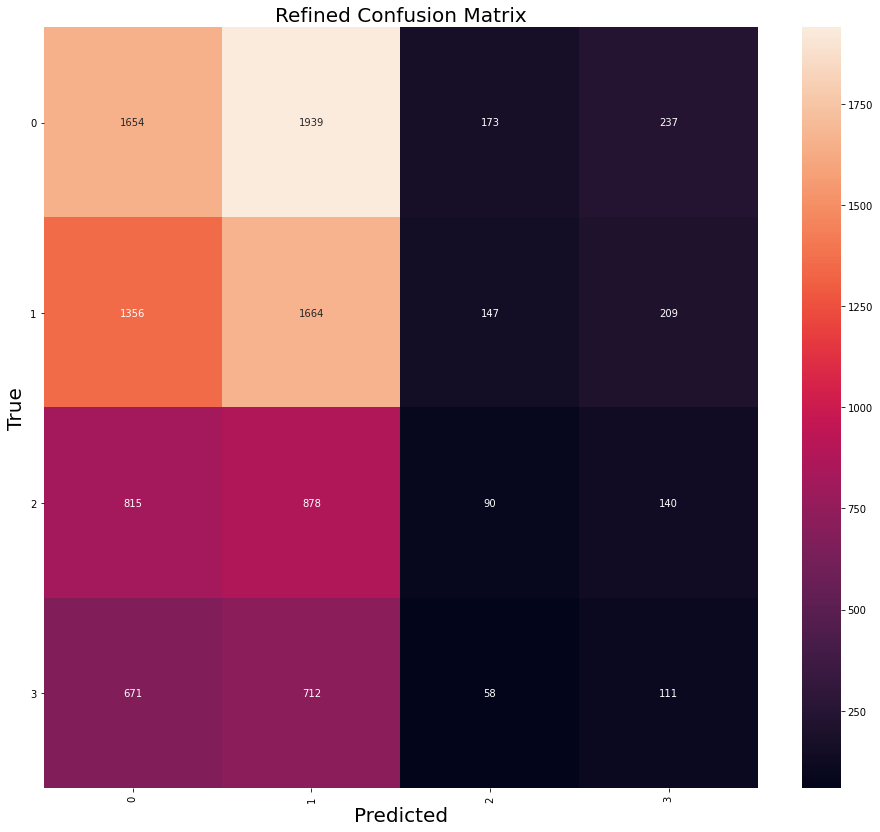

XGBoost accuracy: 0.324212271973466
XGBoost number of mislabeled points out of a total 10854 points : 7335
                   Mid        North        South         West  accuracy  \
precision     0.367883     0.320431     0.192308     0.159254  0.324212   
recall        0.413190     0.492891     0.046802     0.071521  0.324212   
f1-score      0.389222     0.388377     0.075282     0.098711  0.324212   
support    4003.000000  3376.000000  1923.000000  1552.000000  0.324212   

              macro avg  weighted avg  
precision      0.259969      0.292185  
recall         0.256101      0.324212  
f1-score       0.237898      0.291799  
support    10854.000000  10854.000000  


In [23]:
condensed_x_boost, condensed_x_boost_pred, condensed_x_boost_conf, condensed_x_boost_mat, condensed_acc = xgb_me(condensed_train, condensed_test)

In [36]:
british_pred = condensed_x_boost.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)




West     324
North    268
Mid      112
South     28
Name: pred_accent, dtype: int64


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,pred_tally,pred_percent
pred_accent,,
Mid,112,15.300546
North,268,36.612022
South,28,3.825137
West,324,44.262295


In [25]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
West     5821
Name: accent, dtype: int64

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


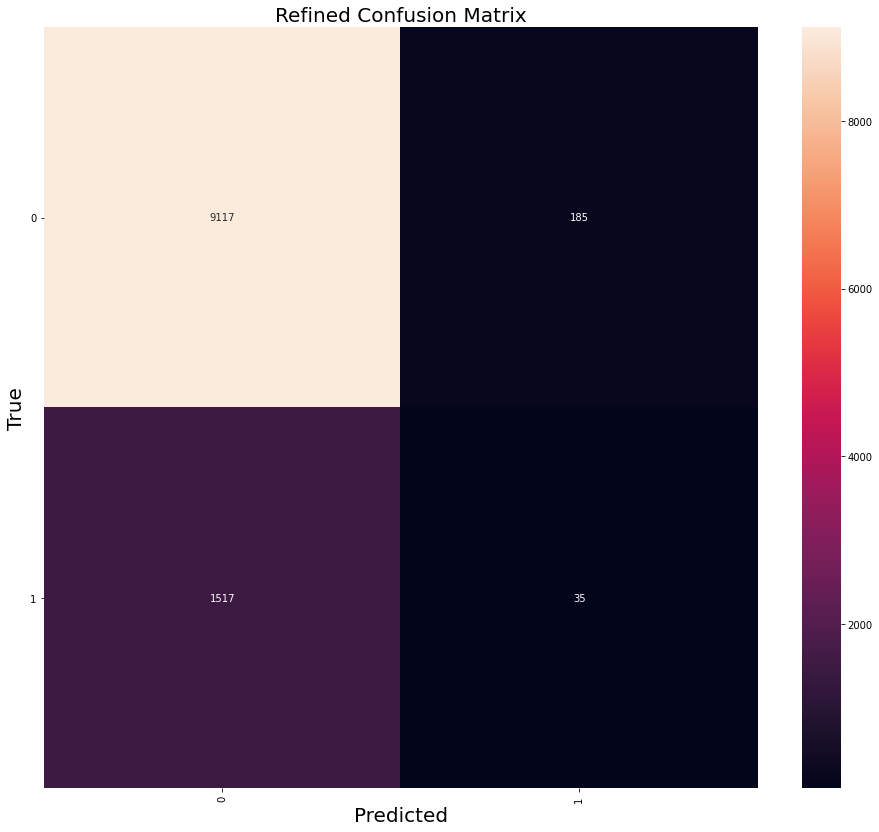

XGBoost accuracy: 0.8431914501566243
XGBoost number of mislabeled points out of a total 10854 points : 1702
                  East         West  accuracy     macro avg  weighted avg
precision     0.857344     0.159091  0.843191      0.508218      0.757502
recall        0.980112     0.022552  0.843191      0.501332      0.843191
f1-score      0.914627     0.039503  0.843191      0.477065      0.789494
support    9302.000000  1552.000000  0.843191  10854.000000  10854.000000


In [26]:
cm_x_boost, cm_x_boost_pred, cm_x_boost_conf, cm_x_boost_mat, cm_acc = xgb_me(condensed_train_two_regions, condensed_tes_two_regions)

In [37]:
british_pred = cm_x_boost.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    649
West     83
Name: pred_accent, dtype: int64


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,pred_tally,pred_percent
pred_accent,,
East,649,88.661202
West,83,11.338798
